In [1]:
import yaml

import tabmemcheck
import statutils

import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib

from sklearn.neighbors import KNeighborsClassifier

# auto-reload
%load_ext autoreload
%autoreload 2

In [2]:
# avoid type-3 fonts
import matplotlib
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_style("whitegrid")
sns.set_context("notebook", rc={'axes.linewidth': 1, 'grid.linewidth': 0.5},  font_scale=1.5)

# The first experiment: 20 few-shot examples, dimension 2, 4, 8 and 16

#### gpt-3.5

In [40]:
results = {}
for d in [2, 4, 8, 16]:
    y_true, y_pred = [], []
    for r in range(1000):
        csv_file = f'datasets/synthetic/linear-classification-d={d}-replication={r}.csv'
        exp_name = f'linear-classification-d={d}-replication={r}-seed-0'

        # load the csv file
        df = pd.read_csv(csv_file)
        feature_names, target_name = df.columns.tolist()[:-1], df.columns.tolist()[-1]
        _, y_data = df[feature_names].values, df[target_name].values

        # load the model predictions
        messages, responses = tabmemcheck.read_chatlog(exp_name, f'chatlogs-d={d}-few-shot=20')
        #print(exp_name, len(messages), len(responses))
        for x in responses:
            pred = 0
            try:
                pred = int(x)
            except:
                print('exception:', x)
            y_pred.append(pred)
            y_true.append(y_data[0])

    statutils.accuracy(y_true, y_pred)

Accuracy: 0.90, 95%-Confidence Interval: (0.88, 0.92)
Accuracy: 0.75, 95%-Confidence Interval: (0.73, 0.78)
Accuracy: 0.62, 95%-Confidence Interval: (0.59, 0.65)
Accuracy: 0.56, 95%-Confidence Interval: (0.53, 0.59)


#### gpt-4

In [4]:
results = {}
for d in [2, 4, 8, 16]:
    y_true, y_pred = [], []
    for r in range(1000):
        csv_file = f'datasets/synthetic/linear-classification-d={d}-replication={r}.csv'
        exp_name = f'linear-classification-d={d}-replication={r}-seed-0'

        # load the csv file
        df = pd.read_csv(csv_file)
        feature_names, target_name = df.columns.tolist()[:-1], df.columns.tolist()[-1]
        _, y_data = df[feature_names].values, df[target_name].values

        # load the model predictions
        messages, responses = tabmemcheck.read_chatlog(exp_name, f'chatlogs-d={d}-few-shot=20-gpt4')
        #print(exp_name, len(messages), len(responses))
        for x in responses:
            pred = 0
            try:
                pred = int(x)
            except:
                print('exception:', x)
            y_pred.append(pred)
            y_true.append(y_data[0])

    statutils.accuracy(y_true, y_pred)

Accuracy: 0.91, 95%-Confidence Interval: (0.89, 0.93), Standard error: 0.01
Accuracy: 0.77, 95%-Confidence Interval: (0.74, 0.80), Standard error: 0.01
Accuracy: 0.62, 95%-Confidence Interval: (0.59, 0.65), Standard error: 0.02
Accuracy: 0.58, 95%-Confidence Interval: (0.55, 0.61), Standard error: 0.02


#### logistic regression

In [46]:
for d in [2, 4, 8, 16]:
    y_true = []
    y_pred = []
    for r in range(1000):
        exp_name = f'linear-classification-d={d}-replication={r}'
        csv_file = f'datasets/synthetic/{exp_name}.csv'

        # load the csv file
        df = pd.read_csv(csv_file)
        feature_names, target_name = df.columns.tolist()[:-1], df.columns.tolist()[-1]
        X_data, y_data = df[feature_names].values, df[target_name]

        # train logistic regression, evaluate via loo
        def logistic_fit_predict(X_train, y_train, testpoint):
            clf = statutils.fit_logistic_regression_cv(X_train, y_train, num_splits=7)
            return clf.predict(testpoint.reshape(1, -1))

        predictions = statutils.loo_eval(
            X_data, y_data, logistic_fit_predict, few_shot=20, max_points=1
        )
        y_true.append(y_data[0])
        y_pred.append(predictions[0])

    # compute the accuracy
    acc, _ = statutils.accuracy(y_true, y_pred)

Accuracy: 0.95, 95%-Confidence Interval: (0.93, 0.96)
Accuracy: 0.93, 95%-Confidence Interval: (0.91, 0.94)
Accuracy: 0.87, 95%-Confidence Interval: (0.84, 0.89)
Accuracy: 0.77, 95%-Confidence Interval: (0.74, 0.80)


### knn

In [47]:
def knn_fit_predict(X_train, y_train, testpoint):
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(X_train, y_train)
    return neigh.predict(testpoint.reshape(1, -1))

# performance of knn
knn_results = {}
for d in [2, 4, 8, 16]:
    y_true = []
    y_pred = []
    for r in range(1000):
        exp_name = f'linear-classification-d={d}-replication={r}'
        csv_file = f'datasets/synthetic/{exp_name}.csv'

        # load the csv file
        df = pd.read_csv(csv_file)
        feature_names, target_name = df.columns.tolist()[:-1], df.columns.tolist()[-1]
        X_data, y_data = df[feature_names].values, df[target_name]

        # train knn, evaluate via loo
        predictions = statutils.loo_eval(
            X_data, y_data, knn_fit_predict, few_shot=20, max_points=1
        )
        y_true.append(y_data[0])
        y_pred.append(predictions[0])

    # compute the accuracy
    acc, _ = statutils.accuracy(y_true, y_pred)

Accuracy: 0.91, 95%-Confidence Interval: (0.89, 0.93)
Accuracy: 0.80, 95%-Confidence Interval: (0.77, 0.82)
Accuracy: 0.71, 95%-Confidence Interval: (0.68, 0.74)
Accuracy: 0.63, 95%-Confidence Interval: (0.60, 0.66)


### tabllm

In [15]:
tabllm_results = pickle.load(open('results/linear-classification-tabllm.pkl', 'rb'))

# mean and confidence intervals
for d in [2, 4, 8, 16]:
    print(d, np.mean(tabllm_results[d]), np.mean(tabllm_results[d]) - 1.645 * np.std(tabllm_results[d]) / np.sqrt(5), np.mean(tabllm_results[d]) + 1.645 * np.std(tabllm_results[d]) / np.sqrt(5))

2 0.6681999999999999 0.6246167502267211 0.7117832497732787
4 0.546 0.5151967435812381 0.576803256418762
8 0.5126000000000001 0.5077290219462618 0.5174709780537383
16 0.5146 0.5077840600648186 0.5214159399351813


### plot

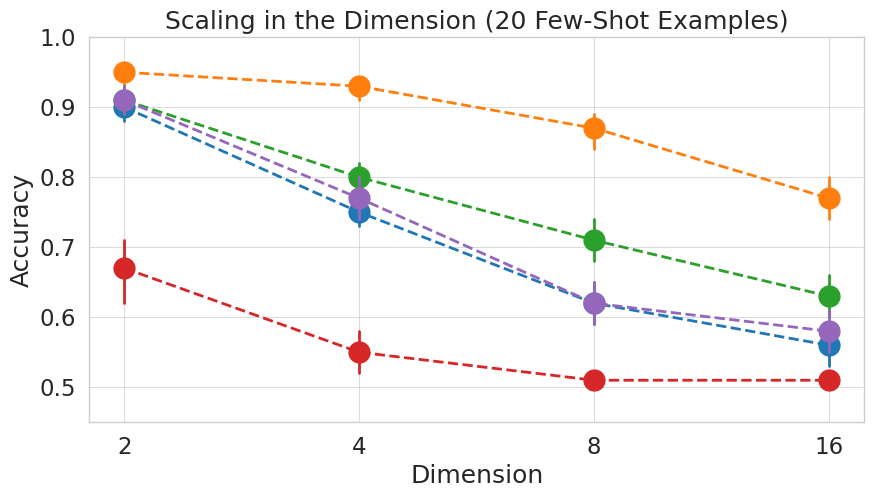

In [16]:
# gpt-3.5
results = {2: [0.90], 4: [0.75], 8: [0.62], 16: [0.56]}
results_lower = {2: [0.88], 4: [0.73], 8: [0.59], 16: [0.53]}
results_upper = {2: [0.92], 4: [0.78], 8: [0.65], 16: [0.59]}

# lr
lr_results = {2: [0.95], 4: [0.93], 8: [0.87], 16: [0.77]}
lr_results_lower = {2: [0.93], 4: [0.91], 8: [0.84], 16: [0.74]}
lr_results_upper = {2: [0.96], 4: [0.94], 8: [0.89], 16: [0.80]}

# knn
knn_results = {2: [0.91], 4: [0.80], 8: [0.71], 16: [0.63]}
knn_results_lower = {2: [0.89], 4: [0.77], 8: [0.68], 16: [0.60]}
knn_results_upper = {2: [0.93], 4: [0.82], 8: [0.74], 16: [0.66]}

# gpt-4
gpt4_results = {2: [0.91], 4: [0.77], 8: [0.62], 16: [0.58]}
gpt4_results_lower = {2: [0.89], 4: [0.74], 8: [0.59], 16: [0.55]}
gpt4_results_upper = {2: [0.93], 4: [0.80], 8: [0.65], 16: [0.61]}

# tabllm
tabllm_results = {2: [0.67], 4: [0.55], 8: [0.51], 16: [0.51]}
tabllm_results_lower = {2: [0.62], 4: [0.52], 8: [0.51], 16: [0.51]}
tabllm_results_upper = {2: [0.71], 4: [0.58], 8: [0.52], 16: [0.52]}

x = [2, 4, 8, 16]
y = [np.mean(results[d]) for d in x]
y_lr = [np.mean(lr_results[d]) for d in x]
y_knn = [np.mean(knn_results[d]) for d in x]
y_tabllm = [np.mean(tabllm_results[d]) for d in x]
y_gpt4 = [np.mean(gpt4_results[d]) for d in x]

# Convert x values and the special GPT-4 x values to categorical labels
x_categories = [str(xi) for xi in [2, 4, 8, 16]]  # Assuming these are all your x values

# Create indices for plotting
x_indices = range(len(x_categories))

plt.figure(figsize=(10, 5))


plt.plot(range(len(x)), y, 'o--', label='GPT-3.5-turbo', lw=2, markersize=15)
for i, d in enumerate(x):
    plt.plot([i, i], [results_lower[d], results_upper[d]], '-', lw=2, color='tab:blue')

plt.plot(range(len(x)), y_lr, 'o--', label='Logistic Regression', lw=2, markersize=15)
for i, d in enumerate(x):
    plt.plot([i, i], [lr_results_lower[d], lr_results_upper[d]], '-', lw=2, color='tab:orange')

plt.plot(range(len(x)), y_knn, 'o--', label='1-Nearest Neighbor', lw=2, markersize=15)
for i, d in enumerate(x):
    plt.plot([i, i], [knn_results_lower[d], knn_results_upper[d]], '-', lw=2, color='tab:green')

plt.plot(range(len(x)), y_tabllm, 'o--', label='TabLLM', lw=2, markersize=15)
for i, d in enumerate(x):
    plt.plot([i, i], [tabllm_results_lower[d], tabllm_results_upper[d]], '-', lw=2, color='tab:red')
    
plt.plot(range(len(x)), y_gpt4, 'o--', label='GPT-4', lw=2, markersize=15)
for i, d in enumerate(x):
    plt.plot([i, i], [gpt4_results_lower[d], gpt4_results_upper[d]], '-', lw=2, color='tab:purple')

# Set x-axis ticks to the categorical labels
plt.xticks(x_indices, x_categories)

plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.title('Scaling in the Dimension (20 Few-Shot Examples)')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.ylim([0.45, 1.0])

# save as pdf
plt.savefig('figures/linear-classification.pdf', bbox_inches='tight')

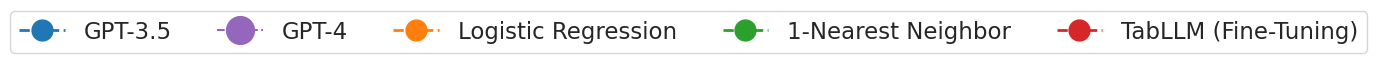

In [10]:
# plot the legend separately
plt.figure(figsize=(15, 1))
plt.plot([], [], 'o--', label='GPT-3.5', lw=2, markersize=15)
plt.plot([], [], 'o--', label='GPT-4', color='tab:purple', markersize=20)
plt.plot([], [], 'o--', label='Logistic Regression', lw=2, markersize=15)
plt.plot([], [], 'o--', label='1-Nearest Neighbor', lw=2, markersize=15)
plt.plot([], [], 'o--', label='TabLLM (Fine-Tuning)', lw=2, markersize=15)
plt.legend(loc='center', ncol=5)
plt.axis('off')
# tight layout
plt.tight_layout()
plt.savefig('figures/linear-classification-legend.pdf', bbox_inches='tight')

# The second experiment: dimension 8, few-shot examples: 10, 20, 50, 100, 200

#### gpt-3.5

In [9]:
results = {}
for few_shot in [10]:
    results[few_shot] = []
    y_true, y_pred = [], []
    for r in range(1000):
        csv_file = f'datasets/synthetic/linear-classification-d=8-replication={r}.csv'
        exp_name = f'linear-classification-d=8-replication={r}-seed-0'

        # load the csv file
        df = pd.read_csv(csv_file)
        feature_names, target_name = df.columns.tolist()[:-1], df.columns.tolist()[-1]
        _, y_data = df[feature_names].values, df[target_name].values

        # load the model predictions
        messages, responses = tabmemcheck.read_chatlog(exp_name, f'chatlogs-d=8-few-shot={few_shot}')
        print(exp_name, len(messages), len(responses))
        for x in responses:
            pred = 0
            try:
                pred = int(x)
            except:
                print('exception:', x)
            y_pred.append(pred)
            y_true.append(y_data[0])

statutils.accuracy(y_true, y_pred)

linear-classification-d=8-replication=0-seed-0 1 1
linear-classification-d=8-replication=1-seed-0 1 1
linear-classification-d=8-replication=2-seed-0 1 1
linear-classification-d=8-replication=3-seed-0 1 1
linear-classification-d=8-replication=4-seed-0 1 1
linear-classification-d=8-replication=5-seed-0 1 1
linear-classification-d=8-replication=6-seed-0 1 1
linear-classification-d=8-replication=7-seed-0 1 1
linear-classification-d=8-replication=8-seed-0 1 1
linear-classification-d=8-replication=9-seed-0 1 1
linear-classification-d=8-replication=10-seed-0 1 1
linear-classification-d=8-replication=11-seed-0 1 1
linear-classification-d=8-replication=12-seed-0 1 1
linear-classification-d=8-replication=13-seed-0 1 1
linear-classification-d=8-replication=14-seed-0 1 1
linear-classification-d=8-replication=15-seed-0 1 1
linear-classification-d=8-replication=16-seed-0 1 1
linear-classification-d=8-replication=17-seed-0 1 1
linear-classification-d=8-replication=18-seed-0 1 1
linear-classification-

(0.6, ConfidenceInterval(low=0.569, high=0.63))

### gpt-4

In [4]:
results = {}
for few_shot in [10, 20, 50, 100, 200, 1000]:
    y_true, y_pred = [], []
    for r in range(1000):
        csv_file = f'datasets/synthetic/linear-classification-d=8-replication={r}.csv'
        exp_name = f'linear-classification-d=8-replication={r}-seed-0'

        # load the csv file
        df = pd.read_csv(csv_file)
        feature_names, target_name = df.columns.tolist()[:-1], df.columns.tolist()[-1]
        _, y_data = df[feature_names].values, df[target_name].values

        # load the model predictions
        messages, responses = tabmemcheck.read_chatlog(exp_name, f'chatlogs-d=8-few-shot={few_shot}-gpt4')
        #print(exp_name, len(messages), len(responses))
        for x in responses:
            pred = 0
            try:
                pred = int(x)
            except:
                print('exception:', x)
            y_pred.append(pred)
            y_true.append(y_data[0])

    statutils.accuracy(y_true, y_pred)

Accuracy: 0.50, 95%-Confidence Interval: (0.47, 0.53), Standard error: 0.02
Accuracy: 0.48, 95%-Confidence Interval: (0.45, 0.52), Standard error: 0.02
Accuracy: 0.51, 95%-Confidence Interval: (0.48, 0.54), Standard error: 0.02
Accuracy: 0.49, 95%-Confidence Interval: (0.46, 0.52), Standard error: 0.02
Accuracy: 0.51, 95%-Confidence Interval: (0.48, 0.54), Standard error: 0.02
Accuracy: 0.77, 95%-Confidence Interval: (0.74, 0.80), Standard error: 0.01


#### logistic regression

In [5]:
for few_shot in [10, 20, 50, 100, 200]:
    y_true = []
    y_pred = []
    for r in range(1000):
        exp_name = f'linear-classification-d=8-replication={r}'
        csv_file = f'datasets/synthetic/{exp_name}.csv'

        # load the csv file
        df = pd.read_csv(csv_file)
        feature_names, target_name = df.columns.tolist()[:-1], df.columns.tolist()[-1]
        X_data, y_data = df[feature_names].values, df[target_name]

        # train logistic regression, evaluate via loo
        def logistic_fit_predict(X_train, y_train, testpoint):
            clf = statutils.fit_logistic_regression_cv(X_train, y_train, num_splits=7 if few_shot > 10 else 3)
            return clf.predict(testpoint.reshape(1, -1))

        predictions = statutils.loo_eval(
            X_data, y_data, logistic_fit_predict, few_shot=few_shot, max_points=1
        )
        y_true.append(y_data[0])
        y_pred.append(predictions[0])

    # compute the accuracy
    acc, _ = statutils.accuracy(y_true, y_pred)

#store results with pickle
#with open('results/linear-classification-fewshot-lr.pkl', 'wb') as f:
#    pickle.dump(lr_results, f)

Accuracy: 0.77, 95%-Confidence Interval: (0.74, 0.80)
Accuracy: 0.84, 95%-Confidence Interval: (0.82, 0.87)
Accuracy: 0.94, 95%-Confidence Interval: (0.92, 0.95)
Accuracy: 0.97, 95%-Confidence Interval: (0.95, 0.98)
Accuracy: 0.98, 95%-Confidence Interval: (0.96, 0.98)


#### knn

In [9]:
def knn_fit_predict(X_train, y_train, testpoint):
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(X_train, y_train)
    return neigh.predict(testpoint.reshape(1, -1))

# performance of knn
knn_results = {}
for few_shot in [10, 20, 50, 100, 200]:
    y_true = []
    y_pred = []
    for r in range(1000):
        exp_name = f'linear-classification-d=8-replication={r}'
        csv_file = f'datasets/synthetic/{exp_name}.csv'

        # load the csv file
        df = pd.read_csv(csv_file)
        feature_names, target_name = df.columns.tolist()[:-1], df.columns.tolist()[-1]
        X_data, y_data = df[feature_names].values, df[target_name]

        # train knn, evaluate via loo
        predictions = statutils.loo_eval(
            X_data, y_data, knn_fit_predict, few_shot=few_shot, max_points=1
        )
        y_true.append(y_data[0])
        y_pred.append(predictions[0])

    # compute the accuracy
    acc, _ = statutils.accuracy(y_true, y_pred)

Accuracy: 0.68, 95%-Confidence Interval: (0.65, 0.71)
Accuracy: 0.72, 95%-Confidence Interval: (0.69, 0.75)
Accuracy: 0.75, 95%-Confidence Interval: (0.72, 0.78)
Accuracy: 0.76, 95%-Confidence Interval: (0.74, 0.79)
Accuracy: 0.80, 95%-Confidence Interval: (0.78, 0.83)


#### tabllm

In [17]:
df = pd.read_csv('results/tabllm_results.csv')
df.head()

results = {}
for d in [10, 20, 50, 100, 200]:
    results[d] = []
    for i_problem in range(5):
        replications = df.iloc[i_problem*5:(i_problem+1)*5][f'{d}']
        results[d].append(replications.mean())

#### plot

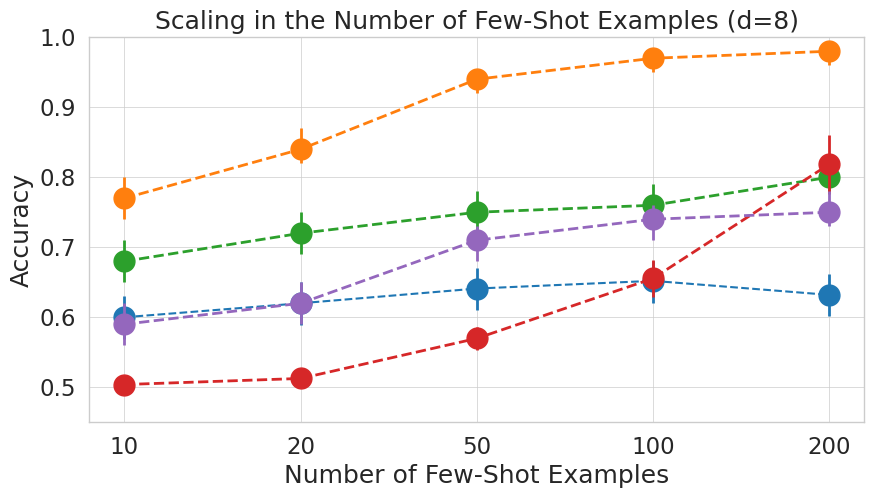

In [26]:
# gpt-3.5
results = {10: [0.6], 20: [0.62], 50: [0.641], 100: [0.652], 200: [0.632]}
results_lower = {10: [0.569], 20: [0.589], 50: [0.611], 100: [0.621], 200: [0.602]}
results_upper = {10: [0.63], 20: [0.65], 50: [0.671], 100: [0.681], 200: [0.662]}

# lr
lr_results = {10: [0.77], 20: [0.84], 50: [0.94], 100: [0.97], 200: [0.98]}
lr_results_lower = {10: [0.74], 20: [0.82], 50: [0.92], 100: [0.95], 200: [0.96]}
lr_results_upper = {10: [0.80], 20: [0.87], 50: [0.95], 100: [0.98], 200: [0.98]}

# knn
knn_results = {10: [0.68], 20: [0.72], 50: [0.75], 100: [0.76], 200: [0.80]}
knn_results_lower = {10: [0.65], 20: [0.69], 50: [0.72], 100: [0.74], 200: [0.78]}
knn_results_upper = {10: [0.71], 20: [0.75], 50: [0.78], 100: [0.79], 200: [0.83]}

# tabllm
tabllm_results = {10: [0.5038787600000001], 20: [0.5125714799999999], 50: [0.5697684000000001], 100: [0.65537776], 200: [0.8184000000000001]}
tabllm_results_lower = {10: [0.49952807518820386], 20: [0.507764750829478], 50: [0.5527545751677777], 100: [0.6284330962638949], 200: [0.7766489731584361]}
tabllm_results_upper = {10: [0.5082294448117963], 20: [0.5173782091705217], 50: [0.5867822248322224], 100: [0.6823224237361052], 200: [0.8601510268415642]}


# gpt-4
gpt4_results = {10: [0.59], 20: [0.62], 50: [0.71], 100: [0.74], 200: [0.75]}
gpt4_results_lower = {10: [0.56], 20: [0.59], 50: [0.68], 100: [0.71], 200: [0.73]}
gpt4_results_upper = {10: [0.62], 20: [0.65], 50: [0.73], 100: [0.76], 200: [0.78]}
# Accuracy: 0.77, 95%-Confidence Interval: (0.74, 0.80), Standard error: 0.01

x = [10, 20, 50, 100, 200]
# y = [np.mean(results[d]) for d in x]
y = [0.6, 0.62, 0.641, 0.652, 0.632]
y_lr = [np.mean(lr_results[d]) for d in x]
y_knn = [np.mean(knn_results[d]) for d in x]
y_gpt4 = [np.mean(gpt4_results[d]) for d in x]
y_tabllm = [np.mean(tabllm_results[d]) for d in x]
#y_min = [np.min(results[d]) for d in x]
#y_max = [np.max(results[d]) for d in x]


# Convert x values to categorical labels (string format)
x_labels = [str(xi) for xi in x]

# Create a mapping of x values to their respective indices
x_indices = range(len(x))

plt.figure(figsize=(10, 5))

# Plot using indices for x-axis
plt.plot(x_indices, y, 'o--', label='GPT-3.5-turbo', markersize=15)
for i, d in enumerate(x):
    plt.vlines(x=i, ymin=np.min(results_lower[d]), ymax=np.max(results_upper[d]), lw=2)

plt.plot(x_indices, y_lr, 'o--', label='Logistic Regression', markersize=15, lw=2)
for i, d in enumerate(x):
    plt.vlines(x=i, ymin=np.min(lr_results_lower[d]), ymax=np.max(lr_results_upper[d]), lw=2, colors='tab:orange')


plt.plot(x_indices, y_knn, 'o--', label='1-Nearest Neighbor', markersize=15, lw=2)
for i, d in enumerate(x):
    plt.vlines(x=i, ymin=np.min(knn_results_lower[d]), ymax=np.max(knn_results_upper[d]), lw=2, colors='tab:green')


plt.plot(x_indices, y_tabllm, 'o--', label='TabLLM', markersize=15, lw=2)
for i, d in enumerate(x):
    plt.vlines(x=i, ymin=np.min(tabllm_results_lower[d]), ymax=np.max(tabllm_results_upper[d]), lw=2, colors='tab:red')

# GPT-4
plt.plot(x_indices, y_gpt4, 'o--', label='GPT-4', markersize=15, lw=2)
for i, d in enumerate(x):
    plt.vlines(x=i, ymin=np.min(gpt4_results_lower[d]), ymax=np.max(gpt4_results_upper[d]), lw=2, colors='tab:purple')

plt.xlabel('Number of Few-Shot Examples')
plt.ylabel('Accuracy')

# Set x-axis ticks to the indices and label them with the x_labels
plt.xticks(x_indices, ['10', '20', '50', '100', '200'])

# Legend positioned below the plot
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.title('Scaling in the Number of Few-Shot Examples (d=8)')

# Set y-axis limits
plt.ylim([0.45, 1.0])

# save as pdf
plt.savefig('figures/linear-classification-fewshot.pdf', bbox_inches='tight')

In [15]:
tabllm_results = pickle.load(open('results/linear-classification-tabllm.pkl', 'rb'))

# print mean per few-shot
for d in [10, 20, 50, 100, 200]:
    print(d, np.mean(replications[d]))

# print 95% confidence intervals per few-shot
for d in [10, 20, 50, 100, 200]:
    print(d, np.mean(replications[d]) - 1.645 * np.std(replications[d]) / np.sqrt(5), np.mean(replications[d]) + 1.645 * np.std(replications[d]) / np.sqrt(5))

10 0.5038787600000001
20 0.5125714799999999
50 0.5697684000000001
100 0.65537776
200 0.8184000000000001
10 0.49952807518820386 0.5082294448117963
20 0.507764750829478 0.5173782091705217
50 0.5527545751677777 0.5867822248322224
100 0.6284330962638949 0.6823224237361052
200 0.7766489731584361 0.8601510268415642


In [29]:
gpt4_results = pickle.load(open('results/linear-classification-fewshot-gpt-4.pkl', 'rb'))

# print mean per few-shot
for d in [100]:
    print(d, np.mean(gpt4_results[d]))

# print 95% confidence intervals per few-shot
for d in [100]:
    print(d, np.mean(gpt4_results[d]) - 1.645 * np.std(gpt4_results[d]) / np.sqrt(3), np.mean(gpt4_results[d]) + 1.645 * np.std(gpt4_results[d]) / np.sqrt(3))

100 0.7233333333333333
100 0.6740849812270426 0.7725816854396239
